---
### Coverage of the network

---
Importing dependencies

In [1]:
import sys; sys.path.insert(1, "./../../../")
from swyft21cm.utils.interpolation import calc_kSpline, interp_pk, interp_plan
from swyft21cm.utils.plot import coveragePlot

import os
import seaborn as sns
import numpy as np
np.random.seed(27);

from scipy import stats
import torch
torch.manual_seed(27);

import swyft as sl
import pytorch_lightning as pl
import pickle

from tabulate import tabulate
import matplotlib.pyplot as plt
plt.rcParams["mathtext.fontset"] = "stix"
%matplotlib inline

---
Copy the store to the local gpu computing node

In [2]:
%%time
if not os.path.exists("/tmp/21cmPk_SeedVar"):
    !cp -r /scratch/p303146/21cmPk_SeedVar* /tmp/

CPU times: user 11 µs, sys: 4 µs, total: 15 µs
Wall time: 17.9 µs


---
Redshifts, Prior, Paths

In [3]:
# Redshifts
reds = [24.359810, 20.219959, 17.111031, 14.457590, 12.456770,
        10.714930, 9.402521, 8.237142, 7.202319, 6.429094]

# Parameters: zeta, Tvir, Rmfp, Lx, E0, alpha
labels = [r'$\zeta$', r'$\log_{10}(T_{\rm vir}^{\rm min})$', r'$R_{\rm mfp}$',
          r'$\log_{10}(L_{\rm X})$', r'$E_0$', r'$\alpha_{\rm X}$']

# True values of the parameters
vtrue = np.array([30, 4.69897, 15, 40.5, 500, 1])

# Priors
vmin = np.array([10, 4.2, 8, 39.5, 100, -0.5])
vmax = np.array([100, 5.2, 22, 41.5, 900, 2.5])

# k-modes from sim box (no cut applied)
kModes = np.load("./../../data/kModes.npy")

# Parameters for interpolation
Nspline_points = 8
Foreground_cut = 0.1
Shot_Noise_cut = 0.8

# Path for mock observation and noise
noisePath = "./../../data/ska_low_noise.npy"
obsPath = "./../../data/mockObs.pkl"

# accelerator for the trainer
accelerator = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
kSpline = calc_kSpline(Foreground_cut, Shot_Noise_cut, Nspline_points)
print('k-modes:', kSpline)

k-modes: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]


---
SKA noise simulated using `ps_eor`

In [5]:
# Instrumental noise level from SKA low: sim using ps_eor
instNoise = np.load(noisePath)

---
Noise model to be used on-the-fly

In [6]:
# Use it as a hook: takes into account the instrumental noise
def noise(out):
    for i in range(len(reds)):
        mu = out['pk_mu_z%.1f'%reds[i]]
        
        # Interpolate the model power spectra (pk_mod)
        splined_mod = interp_plan(k=kModes, pk=mu)
        mu_val = interp_pk(pk_spl=splined_mod, kSpline=kSpline, Nspline_points=Nspline_points)

        # Check for nan values.
        if np.isnan(np.sum(mu_val)):
            mu_val = np.zeros(len(kSpline))

        n = np.float32(np.random.randn(*instNoise[i].shape))*instNoise[i]
        out['pk_z%.1f'%reds[i]] = mu_val + n
    return out

---
Data loaders: Train, Val, Test

In [7]:
zs = sl.ZarrStore("/tmp/21cmPk_SeedVar/")
data_loader_train = zs.get_dataloader(num_workers=0, batch_size=64, idx_range=[0, 16_000],
                                      on_after_load_sample=noise)
data_loader_val = zs.get_dataloader(num_workers=0, batch_size=64, idx_range=[16_000, 18_000],
                                    on_after_load_sample=noise)
data_loader_test = zs.get_dataloader(num_workers=0, batch_size=64, idx_range=[18_000, 20_000],
                                     on_after_load_sample=noise)

---
Trainer, callbacks, logger

In [8]:
logger = pl.loggers.TensorBoardLogger("./lightning_logs", name = "post_1D_2D_coverage")
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor = 'val_loss', save_top_k=1)
callbacks = [
    pl.callbacks.LearningRateMonitor(),
    pl.callbacks.EarlyStopping("val_loss", patience=8),
    model_checkpoint
]

In [9]:
trainer = sl.SwyftTrainer(accelerator=accelerator, max_epochs=100, logger=logger,
                          callbacks=callbacks, precision=64)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


---
Network architecture

In [10]:
class Network(sl.SwyftModule):
    def __init__(self, lr=1e-3, gamma=1.):
        super().__init__()
        self.n_features = 64
        self.optimizer_init = sl.OptimizerInit(torch.optim.Adam, dict(lr = lr),
                                                  torch.optim.lr_scheduler.ExponentialLR,
                                                  dict(gamma = gamma, verbose=False))
        marginals = self.get_marginals(n_params=len(vtrue))
        self.l = torch.nn.Linear(80, self.n_features)
        
        # Train 1D ratios
        self.logratios1 = sl.LogRatioEstimator_1dim(num_features=self.n_features,
                                                    num_params=len(vtrue),
                                                    hidden_features=256,
                                                    num_blocks=3,
                                                    dropout=0.2,
                                                    varnames='z')
        
        # Train 2D ratios
        self.logratios2 = sl.LogRatioEstimator_Ndim(num_features=self.n_features,
                                                    marginals=marginals,
                                                    hidden_features=256,
                                                    num_blocks=3,
                                                    dropout=0.2,
                                                    varnames ='z')

    @staticmethod
    def get_marginals(n_params):
        marginals = []
        for i in range(n_params):
            for j in range(n_params):
                if j>i: marginals.append((i, j))
        return tuple(marginals)
        
    def forward(self, A, B):
        x = torch.cat([A['pk_z%.1f'%zi] for zi in reds], axis=1)
        x = self.l(x)
        z = B['z']
        ratios_1 = self.logratios1(x, z)
        ratios_2 = self.logratios2(x, z)
        return ratios_1, ratios_2

In [11]:
network = Network(lr=1e-3, gamma=0.95)

---
Training the network

In [12]:
%%time
if os.path.exists("./output/01_trainedLogRatios_20k.pt"):
    network.load_state_dict(torch.load("./output/01_trainedLogRatios_20k.pt"))
else:
    trainer.fit(network, data_loader_train, data_loader_val)

CPU times: user 19.5 ms, sys: 36.8 ms, total: 56.3 ms
Wall time: 56.7 ms


---
Function to translate the values between (0 - 1) to ($v_{\rm min}$ - $v_{\rm max}$).

In [13]:
def uv(u):
    return u * (vmax - vmin) + vmin

---
Get the test samples to use for coverage estimation

In [14]:
%%time
allSamples = zs.get_sample_store()
newSamples = {}

for i in range(len(reds)):
    newSamples['pk_z%.1f'%reds[i]] = []
newSamples['z'] = []
    
for j in range(18_000, 19_000):
    noisy = noise(allSamples[j])
    for i in range(len(reds)):
        newSamples['pk_z%.1f'%reds[i]].append(noisy['pk_z%.1f'%reds[i]])
    newSamples['z'].append(noisy['z'])

/home3/p303146/Projects/swyft21cm/analysis/inference/./../../../swyft21cm/utils/interpolation.py:15: RuntimeWarning: divide by zero encountered in log10
  return scipy.interpolate.splrep(k, np.log10(pk), s=0)


CPU times: user 1.31 s, sys: 99.3 ms, total: 1.41 s
Wall time: 1.42 s


---
Now estimate the coverage using these test samples

In [15]:
%%time
if os.path.exists("./output/02_coverageData_20k.pkl"):
    file = open("./output/02_coverageData_20k.pkl", "rb")
    coverage_samples = pickle.load(file)
    file.close()
else:
    prior_samples = sl.Samples(z=uv(np.random.rand(10_000, 6)).astype('f'))
    coverage_samples = trainer.test_coverage(network, sl.Samples(newSamples), prior_samples)

CPU times: user 2.35 ms, sys: 805 µs, total: 3.16 ms
Wall time: 6.8 ms


---
Save the coverage data

In [16]:
if not os.path.exists("./output/02_coverageData_20k.pkl"):
    open_file = open("./output/02_coverageData_20k.pkl", "wb")
    pickle.dump(coverage_samples, open_file)
    open_file.close()

---
Corner plot of coverage

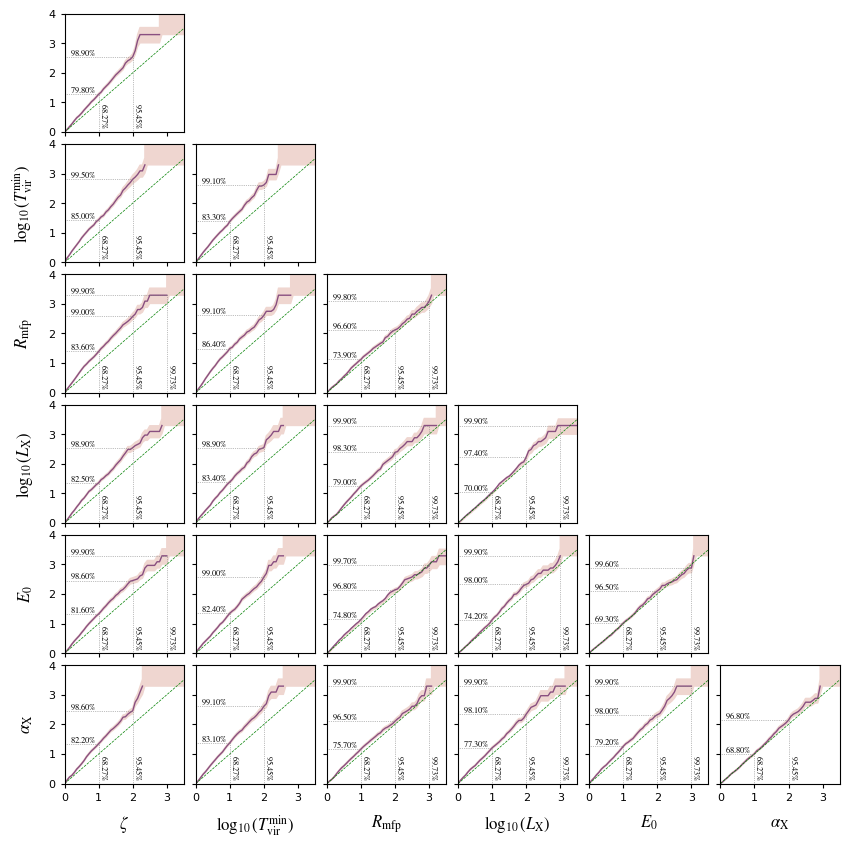

In [17]:
cmap = sns.cubehelix_palette(start=0, light=0.98, dark=0.4, as_cmap=True)
coveragePlot(coverage_samples=coverage_samples, labels=labels, cmap=cmap)